In [12]:
# Import core libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore') # Let's hide the annoying minor warnings for cleaner output

# Load the data
# Use the direct CSV filename; Colab typically extracts the CSV to the root path
file_path = 'default of credit card clients.csv'
df = pd.read_csv(file_path)

# Drop the 'ID' column as it is not a feature
df = df.drop('ID', axis=1)

# Define Target (y) and Features (X)
TARGET_COL = 'dpnm'
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

# Define column types for preprocessing (based on the dataset structure)
# These columns are discrete categories (even if stored as numbers) and need OHE
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Everything else is a high-magnitude numeric variable, so we must scale it
numerical_features = X.columns.drop(categorical_features).tolist()

print(f"Target Column: {TARGET_COL}")
print(f"Numerical Features (to Scale): {numerical_features}")
print(f"Categorical Features (to Encode): {categorical_features}")

# 1. Pipeline for Numerical Features (Cleaning & Scaling)
# Imputing the mean just in case, for a robust pipeline (required step)
# Scaling with StandardScaler is non-negotiable for Logistic Regression
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 2. Pipeline for Categorical Features (Cleaning & Encoding)
# Filling any missing categories with the most common value
# Using OneHotEncoder to make categories machine-readable
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the Column Transformer to apply the correct steps to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

# Create the Full ML Pipeline: Preprocessor + Model
# Wrapping everything up so we can call .fit() just once
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42)) # Using a simple, fast classifier for our baseline
])

# Split the data into Training (80%) and Testing (20%) sets
# Stratify ensures we have a balanced ratio of defaulters in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# TRAIN THE MODEL: This is where all the preprocessing, scaling, and training happens!
print("\nTraining model...")
full_pipeline.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the test set
y_pred = full_pipeline.predict(X_test)

# Evaluate the model (Mandatory step for project completeness)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\n--- Model Evaluation (Classification) ---")
print(f"Accuracy Score: {accuracy*100:.2f}%")
print("\nClassification Report:\n", report)

Target Column: dpnm
Numerical Features (to Scale): ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Categorical Features (to Encode): ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

Training set size: 24000 samples
Testing set size: 6000 samples

Training model...
Model training complete.

--- Model Evaluation (Classification) ---
Accuracy Score: 81.70%

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000



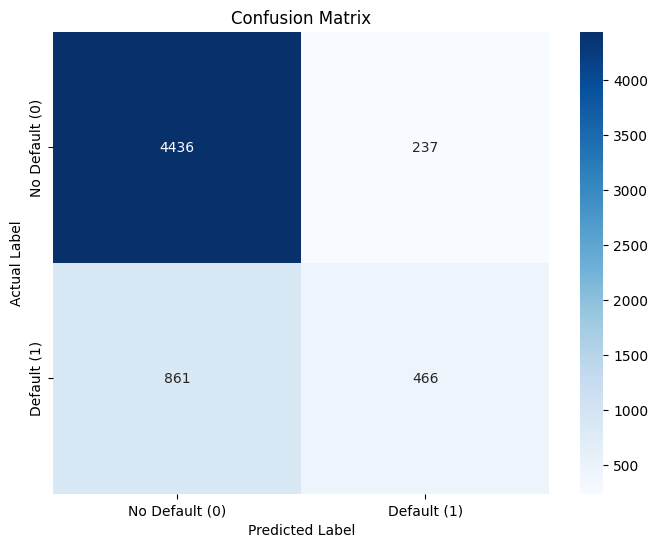

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

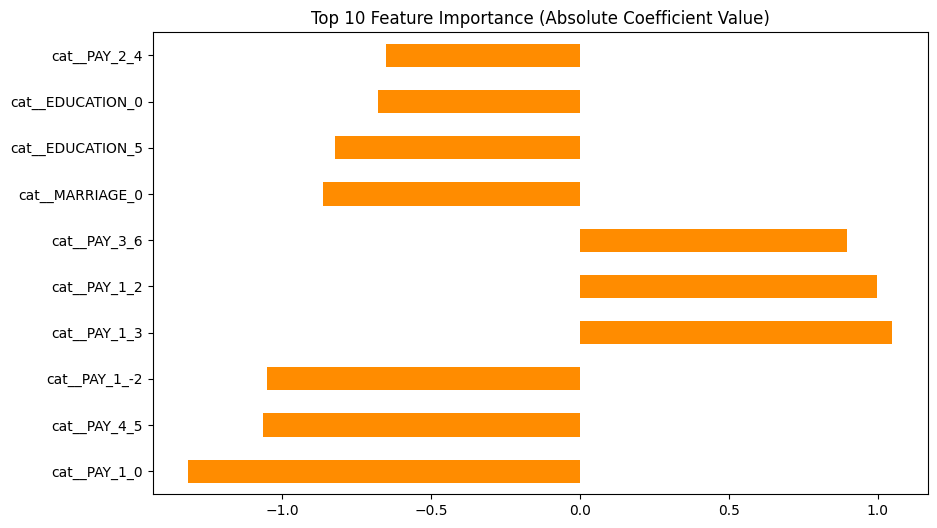

In [14]:
# Pulling the feature names after OHE and the coefficients from the trained model
feature_names = full_pipeline['preprocessor'].get_feature_names_out()
coefficients = full_pipeline['classifier'].coef_[0]

# Create a Series for easy sorting
feature_importance = pd.Series(coefficients, index=feature_names)

# Plot the top 10 absolute (most influential) features
# We look at absolute value since a strong negative effect is just as important as a positive one
top_10 = feature_importance.abs().nlargest(10).index
plt.figure(figsize=(10, 6))
feature_importance[top_10].plot(kind='barh', color='darkorange')
plt.title('Top 10 Feature Importance (Absolute Coefficient Value)')
plt.show()